
# EDA · Saber 11 (2019) — Nariño y Pasto · **TFM Data Science**

Este cuaderno desarrolla un **Análisis Exploratorio de Datos (EDA)** profesional sobre la cohorte **Saber 11 – 2016**, con foco en **Nariño** (y corte específico **Pasto**).  
El EDA está **alineado a los objetivos del TFM**: construir una base confiable de entrada para estimar, más adelante, el **Valor Agregado (VA)** y la **Contribución Relativa (CR)** del programa **Ingeniería de Sistemas – Universidad Mariana** al comparar **Saber 11 (entrada)** vs **Saber Pro (salida)**.

### Qué persigue este EDA
- **Calidad de datos**: unificar 2019_1 + 2019_2, limpiar tipos, normalizar textos, validar rangos y duplicados.
- **Caracterización de entrada** (baseline): puntajes globales y por áreas en Nariño / Pasto.
- **Contexto sociodemográfico**: género, estrato, naturaleza del colegio y jornada.
- **Estructuras agregadas** listas para VA/CR**: resúmenes por colegio y municipio exportados como insumo para el modelado.
- **Gráficas explicativas**: cada figura responde a una pregunta de negocio del TFM (ver notas bajo cada gráfico).

> **Nota**: Este cuaderno **no** calcula VA ni CR. Deja listos los **features** de entrada (Saber 11) que luego se cruzarán con **Saber Pro** por cohorte.


In [2]:

import os
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (9, 5),
    "axes.grid": True
})

print("Libs OK")

Libs OK



## 1) Lectura y unión de fuentes

Archivos oficiales ICFES (TXT `;`) de **2019**: primer y segundo semestre.  
**Edite las rutas si cambian los nombres.**


In [3]:

FILE_2016_1 = "Examen_Saber_11_20191.txt"
FILE_2016_2 = "Examen_Saber_11_20192.txt"

# Columnas de interés (tolerante: si falta alguna, el lector no falla)
COLS = [
    # Ubicación y colegio
    "cole_cod_depto_ubicacion","cole_cod_mcpio_ubicacion",
    "cole_depto_ubicacion","cole_mcpio_ubicacion",
    "cole_nombre_establecimiento","cole_naturaleza","cole_area_ubicacion","cole_jornada","cole_genero",
    # Estudiante / familia
    "estu_genero","estu_inse_individual","fami_estratovivienda",
    # Puntajes
    "punt_global","punt_matematicas","punt_lectura_critica",
    "punt_sociales_ciudadanas","punt_c_naturales","punt_ingles",
    # Meta
    "periodo"
]

def safe_read(path, cols):
    if not os.path.exists(path):
        print(f"⚠️ No se encontró: {path}")
        return pd.DataFrame(columns=cols)
    df = pd.read_csv(path, sep=";", encoding="latin1", low_memory=False)
    keep = [c for c in cols if c in df.columns]
    return df[keep].copy()

df1 = safe_read(FILE_2016_1, COLS)
df2 = safe_read(FILE_2016_2, COLS)
df = pd.concat([df1, df2], ignore_index=True)
print("Dimensiones combinadas:", df.shape)
df.head(3)

Dimensiones combinadas: (680893, 19)


,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_depto_ubicacion,cole_mcpio_ubicacion,cole_nombre_establecimiento,cole_naturaleza,cole_area_ubicacion,cole_jornada,cole_genero,estu_genero,estu_inse_individual,fami_estratovivienda,punt_global,punt_matematicas,punt_lectura_critica,punt_sociales_ciudadanas,punt_c_naturales,punt_ingles,periodo
0,76.0,76147.0,VALLE,CARTAGO,LA PRESENTACIÃN,NO OFICIAL,URBANO,MAÃANA,MIXTO,F,59.203213,Estrato 3,268,59,54,50,49,60.0,20191
1,11.0,11001.0,BOGOTA,BOGOTÃ D.C.,COLEGIO VIRTUAL SIGLO XXI,NO OFICIAL,URBANO,TARDE,MIXTO,M,64.567657,Estrato 3,356,73,69,69,72,77.0,20191
2,25.0,25175.0,CUNDINAMARCA,CHÃA,COLEGIO SANTO TOMAS DE CHIA ...,NO OFICIAL,RURAL,COMPLETA,MIXTO,F,61.596165,NaN,299,54,66,67,50,66.0,20191



## 2) Limpieza / Normalización

- Tipos numéricos para puntajes y códigos de ubicación.  
- Normalización robusta de textos (quita tildes/espacios no rompibles, mayúsculas).  
- Eliminación de duplicados.


In [4]:

# 2.1 Puntajes a numéricos
punt_cols = ["punt_global","punt_matematicas","punt_lectura_critica",
             "punt_sociales_ciudadanas","punt_c_naturales","punt_ingles"]
for c in punt_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 2.2 Códigos a enteros (si existen)
for c in ["cole_cod_depto_ubicacion","cole_cod_mcpio_ubicacion"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

# 2.3 Normalizador de texto
def norm_text(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.replace("\xa0"," ", regex=False).str.strip()
    s = s.apply(lambda x: "".join(ch for ch in unicodedata.normalize("NFKD", x) if not unicodedata.combining(ch)))
    return s.str.upper()

for c in ["cole_depto_ubicacion","cole_mcpio_ubicacion","cole_nombre_establecimiento","cole_naturaleza",
          "cole_area_ubicacion","cole_jornada","cole_genero","estu_genero","fami_estratovivienda"]:
    if c in df.columns:
        df[c] = norm_text(df[c])

# 2.4 Duplicados
before = len(df)
df = df.drop_duplicates()
print("Duplicados eliminados:", before - len(df))

df.info()

Duplicados eliminados: 155
<class 'pandas.core.frame.DataFrame'>
Index: 680738 entries, 0 to 680892
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   cole_cod_depto_ubicacion     576111 non-null  Int64  
 1   cole_cod_mcpio_ubicacion     576111 non-null  Int64  
 2   cole_depto_ubicacion         680738 non-null  object 
 3   cole_mcpio_ubicacion         680738 non-null  object 
 4   cole_nombre_establecimiento  680738 non-null  object 
 5   cole_naturaleza              680738 non-null  object 
 6   cole_area_ubicacion          680738 non-null  object 
 7   cole_jornada                 680738 non-null  object 
 8   cole_genero                  680738 non-null  object 
 9   estu_genero                  680738 non-null  object 
 10  estu_inse_individual         558139 non-null  float64
 11  fami_estratovivienda         680738 non-null  object 
 12  punt_global                  680738 


## 3) Enfoque regional: **Nariño** y **Pasto**

Se aplican filtros por **código** y, como respaldo, por **texto normalizado**.


In [5]:

mask_narino = (
    (("cole_cod_depto_ubicacion" in df.columns) & (df["cole_cod_depto_ubicacion"] == 52))
    | (("cole_depto_ubicacion" in df.columns) & (df["cole_depto_ubicacion"] == "NARINO"))
)

mask_pasto = mask_narino & (
    (("cole_cod_mcpio_ubicacion" in df.columns) & (df["cole_cod_mcpio_ubicacion"] == 52001))
    | (("cole_mcpio_ubicacion" in df.columns) & (df["cole_mcpio_ubicacion"] == "PASTO"))
)

df_narino = df[mask_narino].copy()
df_pasto  = df[mask_pasto].copy()

print("Nariño:", df_narino.shape, " | Pasto:", df_pasto.shape)
display(df_narino.head(3))

Nariño: (18121, 19)  | Pasto: (5349, 19)


,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_depto_ubicacion,cole_mcpio_ubicacion,cole_nombre_establecimiento,cole_naturaleza,cole_area_ubicacion,cole_jornada,cole_genero,estu_genero,estu_inse_individual,fami_estratovivienda,punt_global,punt_matematicas,punt_lectura_critica,punt_sociales_ciudadanas,punt_c_naturales,punt_ingles,periodo
7,52,52001,NARIAO,PASTO,COL ESTUDIAR AULA SIN FRONTERAS,NO OFICIAL,URBANO,MAAANA,MIXTO,F,61.208649,NAN,243,49,58,43,44,51.0,20191
99,52,52560,NARIAO,POTOSA,INSTITUTO DE EDUCACIAN TACNICA INESUR,NO OFICIAL,URBANO,SABATINA,MIXTO,F,NaN,NAN,231,37,49,53,46,45.0,20191
104,52,52001,NARIAO,PASTO,COLEGIO MI PEQUEAO MUNDO GIMNASIO LOS ANDES,NO OFICIAL,URBANO,MAAANA,MIXTO,M,79.124832,ESTRATO 4,337,66,72,69,63,67.0,20191



## 4) Chequeos de calidad

Sanity checks mínimos para garantizar confiabilidad del baseline:
- Porcentaje de nulos en puntajes.
- Rango plausible de puntajes (0–500 aprox.).


In [6]:

# 4.1 Nulos en puntajes (Nariño)
nulls = df_narino[punt_cols].isna().mean().sort_values(ascending=False).to_frame("pct_null")
print("Porcentaje de nulos (Nariño):")
display((nulls*100).round(2))

# 4.2 Rango plausible
rmin = df_narino[punt_cols].min()
rmax = df_narino[punt_cols].max()
rng = pd.DataFrame({"min": rmin, "max": rmax})
print("Rango de puntajes observado (Nariño):")
display(rng)

Porcentaje de nulos (Nariño):


,pct_null
punt_ingles,0.81
punt_global,0.00
punt_matematicas,0.00
punt_lectura_critica,0.00
punt_sociales_ciudadanas,0.00
punt_c_naturales,0.00


Rango de puntajes observado (Nariño):


,min,max
punt_global,95.0,452.0
punt_matematicas,15.0,100.0
punt_lectura_critica,0.0,100.0
punt_sociales_ciudadanas,17.0,100.0
punt_c_naturales,0.0,100.0
punt_ingles,0.0,100.0



## 5) Descriptivos estadísticos (baseline de entrada)

Medidas de tendencia central y dispersión en **Nariño** y **Pasto**.


In [7]:

desc_narino = df_narino[punt_cols].describe().T
desc_pasto  = df_pasto[punt_cols].describe().T

print("Descriptivos — Nariño")
display(desc_narino)
print("Descriptivos — Pasto")
display(desc_pasto)

Descriptivos — Nariño


,count,mean,std,min,25%,50%,75%,max
punt_global,18121.0,245.081728,52.557994,95.0,205.0,242.0,282.0,452.0
punt_matematicas,18121.0,50.784008,12.371469,15.0,42.0,51.0,60.0,100.0
punt_lectura_critica,18121.0,51.347387,10.615428,0.0,44.0,52.0,59.0,100.0
punt_sociales_ciudadanas,18121.0,45.799514,12.020068,17.0,36.0,45.0,55.0,100.0
punt_c_naturales,18121.0,48.677060,11.268973,0.0,40.0,48.0,57.0,100.0
punt_ingles,17974.0,47.420107,12.155479,0.0,38.0,47.0,56.0,100.0


Descriptivos — Pasto


,count,mean,std,min,25%,50%,75%,max
punt_global,5349.0,268.777155,51.350221,127.0,231.0,269.0,306.0,434.0
punt_matematicas,5349.0,55.330529,11.831540,17.0,47.0,56.0,64.0,100.0
punt_lectura_critica,5349.0,55.758086,10.133541,24.0,49.0,56.0,63.0,100.0
punt_sociales_ciudadanas,5349.0,50.546831,12.283758,19.0,41.0,50.0,60.0,100.0
punt_c_naturales,5349.0,53.399327,10.961030,23.0,45.0,53.0,61.0,100.0
punt_ingles,5306.0,53.764795,12.099294,22.0,46.0,54.0,62.0,100.0



## 6) Perfil sociodemográfico (para análisis causal posterior)

Estas distribuciones explican **heterogeneidad de entrada**. Serán controles en modelos de VA/CR (evitan sesgos por composición):
- **Género** (`estu_genero`)
- **Estrato** (`fami_estratovivienda`)
- **Naturaleza del colegio** (`cole_naturaleza`)
- **Jornada** (`cole_jornada`)


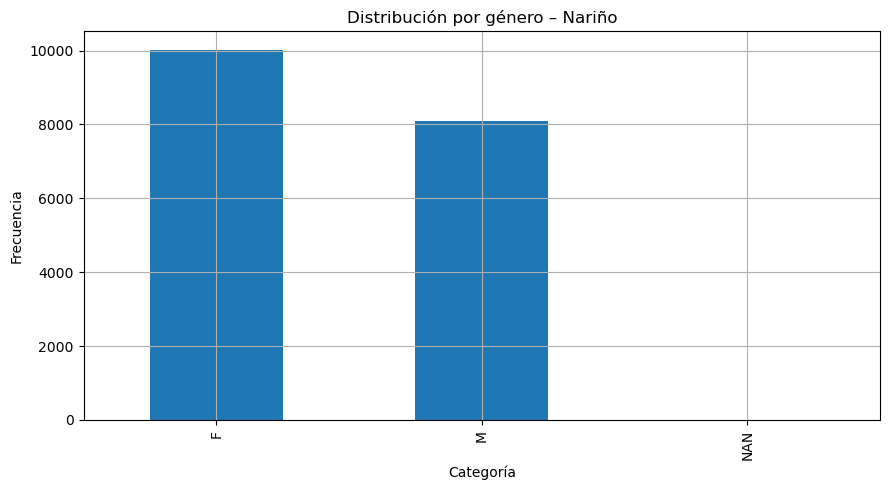

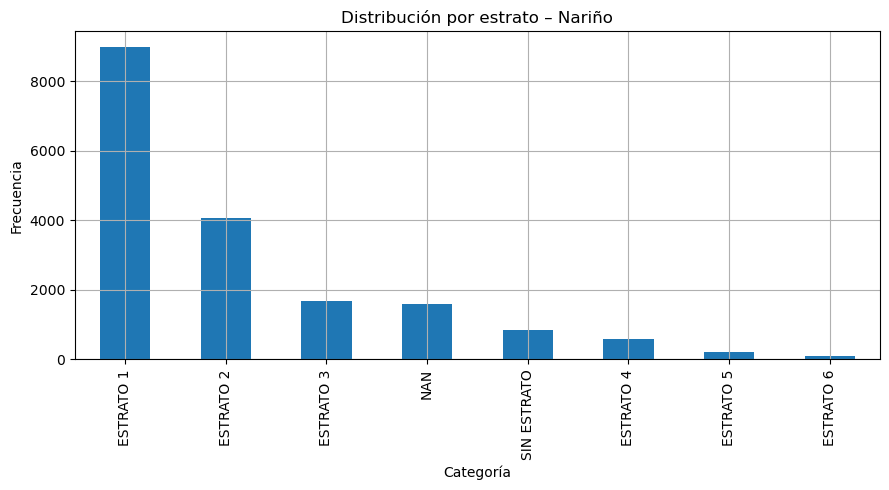

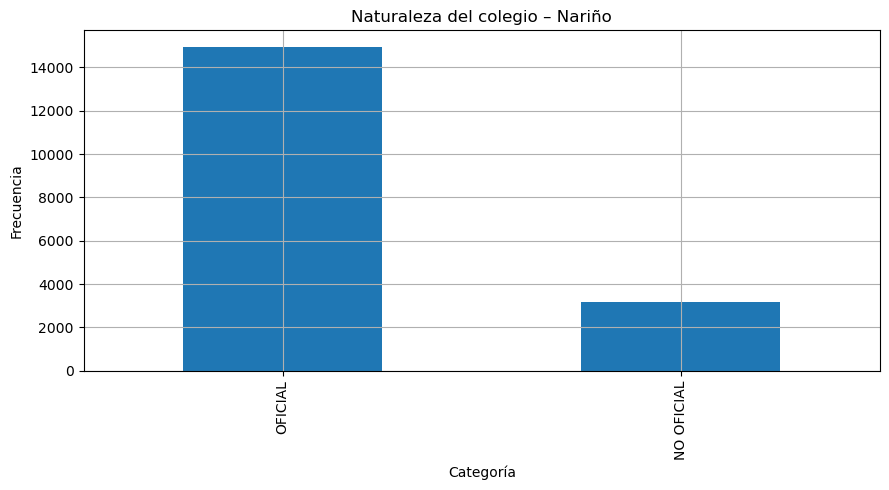

C:\Users\sebas\AppData\Local\Temp\ipykernel_11192\1283191449.py:8: UserWarning: Glyph 145 (\x91) missing from current font.
  plt.tight_layout()
c:\Users\sebas\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 145 (\x91) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


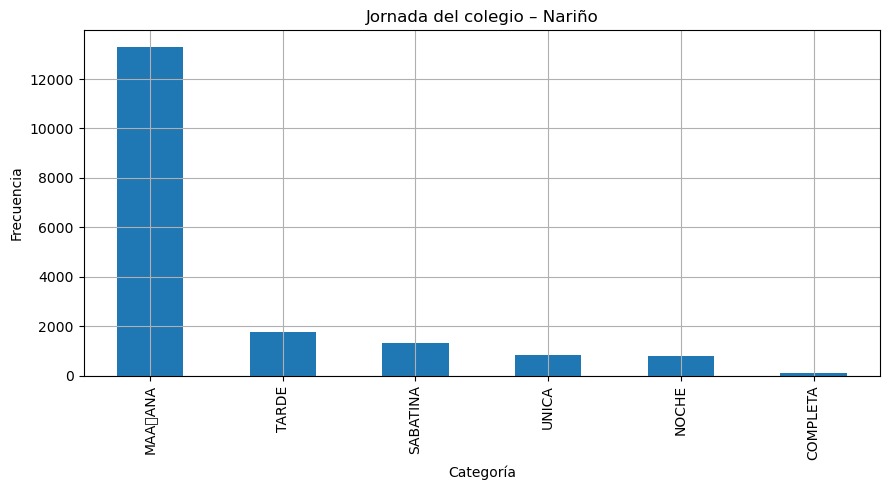

In [8]:

def bar_count(series, title):
    vc = series.value_counts(dropna=False)
    plt.figure()
    vc.plot(kind="bar")
    plt.title(title)
    plt.xlabel("Categoría")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

if "estu_genero" in df_narino.columns:
    bar_count(df_narino["estu_genero"], "Distribución por género – Nariño")

if "fami_estratovivienda" in df_narino.columns:
    bar_count(df_narino["fami_estratovivienda"], "Distribución por estrato – Nariño")

if "cole_naturaleza" in df_narino.columns:
    bar_count(df_narino["cole_naturaleza"], "Naturaleza del colegio – Nariño")

if "cole_jornada" in df_narino.columns:
    bar_count(df_narino["cole_jornada"], "Jornada del colegio – Nariño")

1. Distribución por género – Nariño

La tendencia se mantiene: mayor proporción de mujeres (≈10.000) frente a hombres (≈8.000). Esta composición constante refuerza la importancia de considerar el género como variable de control en el cálculo del Valor Agregado (VA) y la Contribución Relativa (CR), pues el predominio femenino puede influir en los resultados agregados.

2. Distribución por estrato – Nariño

El estrato 1 sigue siendo dominante, seguido por estrato 2 y con una proporción decreciente en los demás estratos. Los estratos altos prácticamente no tienen presencia. Este patrón confirma la vulnerabilidad socioeconómica estructural de la región y la necesidad de incluir esta variable en los modelos analíticos para no atribuir al efecto universitario lo que corresponde a condiciones de origen.

3. Naturaleza del colegio – Nariño

La gran mayoría de estudiantes proviene de instituciones oficiales, con una proporción ampliamente mayor respecto a los no oficiales. Este hallazgo ratifica que el sistema público es el principal canal de acceso a la educación media en el departamento, lo que repercute directamente en el perfil de ingreso a la educación superior.

4. Jornada del colegio – Nariño

La jornada de la mañana continúa siendo la más representativa, con una presencia mucho mayor a las demás modalidades. Este patrón homogéneo mantiene la consistencia observada en años anteriores, reduciendo el peso de esta variable en la explicación de diferencias académicas.


**Uso en el TFM:** estas variables se incorporarán como **controles** al estimar el desempeño esperado en Saber Pro condicional a las características de entrada (baseline), permitiendo aislar el **efecto agregado** atribuible a la formación universitaria.



## 7) Distribución de puntajes (Nariño vs Pasto)

Las curvas y boxplots permiten visualizar **nivel y dispersión** de entrada por territorio.


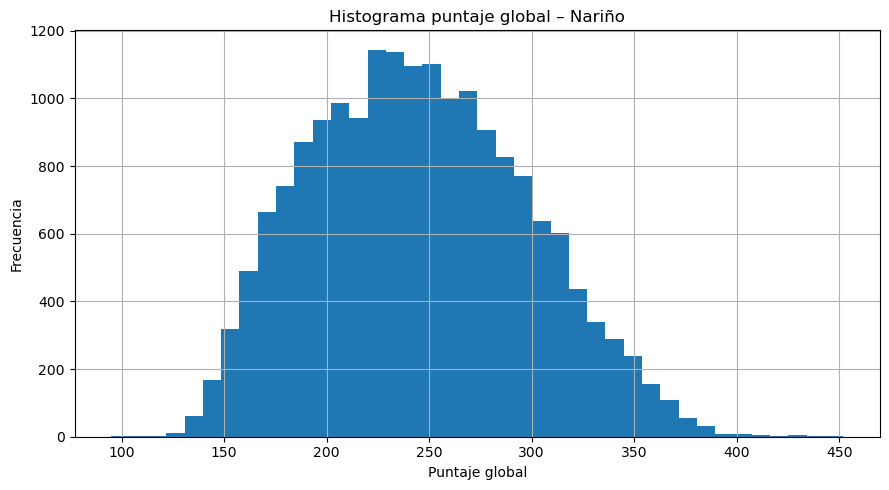

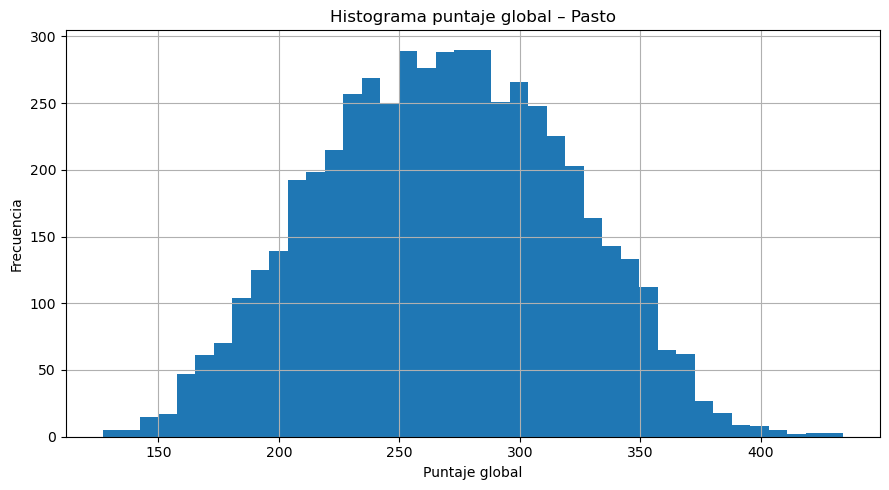

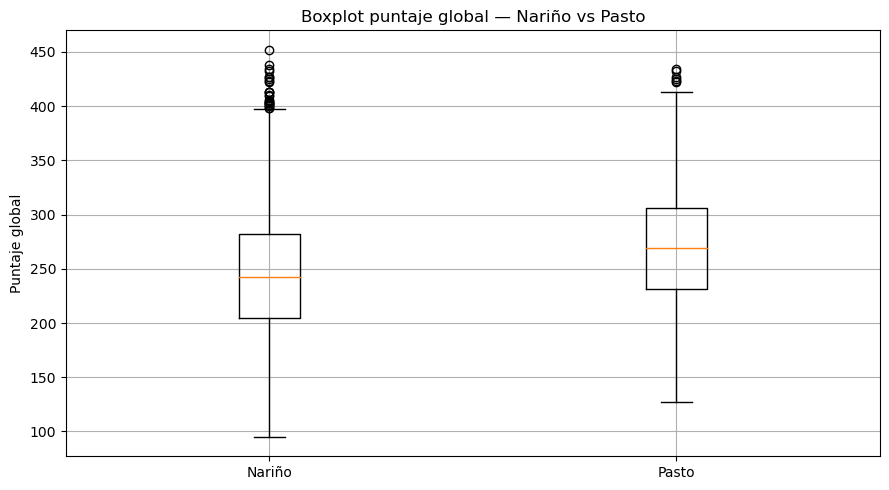

In [9]:

def hist_one(series, title, xlabel):
    if series.notna().any():
        plt.figure()
        series.dropna().plot(kind="hist", bins=40)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Frecuencia")
        plt.tight_layout()
        plt.show()

# Hist global
hist_one(df_narino["punt_global"], "Histograma puntaje global – Nariño", "Puntaje global")
hist_one(df_pasto["punt_global"],  "Histograma puntaje global – Pasto",  "Puntaje global")

# Boxplot comparativo
vals, labels = [], []
if df_narino["punt_global"].notna().any():
    vals.append(df_narino["punt_global"].dropna()); labels.append("Nariño")
if df_pasto["punt_global"].notna().any():
    vals.append(df_pasto["punt_global"].dropna());  labels.append("Pasto")

if vals:
    plt.figure()
    plt.boxplot(vals, labels=labels, vert=True)
    plt.title("Boxplot puntaje global — Nariño vs Pasto")
    plt.ylabel("Puntaje global")
    plt.tight_layout()
    plt.show()

5. Histograma de puntaje global – Nariño

La distribución de puntajes globales es aproximadamente normal, centrada en torno a los 240–250 puntos. Se observa dispersión moderada y presencia de casos extremos, lo que sugiere estabilidad en el rendimiento promedio departamental frente a los años anteriores.

6. Histograma de puntaje global – Pasto

En Pasto, la distribución se concentra entre 250 y 310 puntos, con una media superior a la del departamento. La forma más compacta indica mayor homogeneidad en los resultados urbanos y confirma la ventaja relativa de la capital en los puntajes de entrada.

7. Boxplot puntaje global — Nariño vs Pasto

El boxplot muestra que Pasto tiene una mediana más alta que Nariño y menor dispersión interna, aunque se mantienen outliers en ambos casos. Este hallazgo refuerza la necesidad de ajustar los cálculos de VA y CR al contexto inicial, diferenciando claramente entre estudiantes urbanos y departamentales.


**Uso en el TFM:** estas figuras justifican los **ajustes de baseline** por territorio (municipio) cuando se calcule VA/CR, y permiten reportar si Pasto difiere sistemáticamente del resto del departamento.



## 8) Comparación por áreas (medias)

Promedios por competencia para Nariño vs Pasto. Útil para identificar **áreas deficitarias** de entrada.


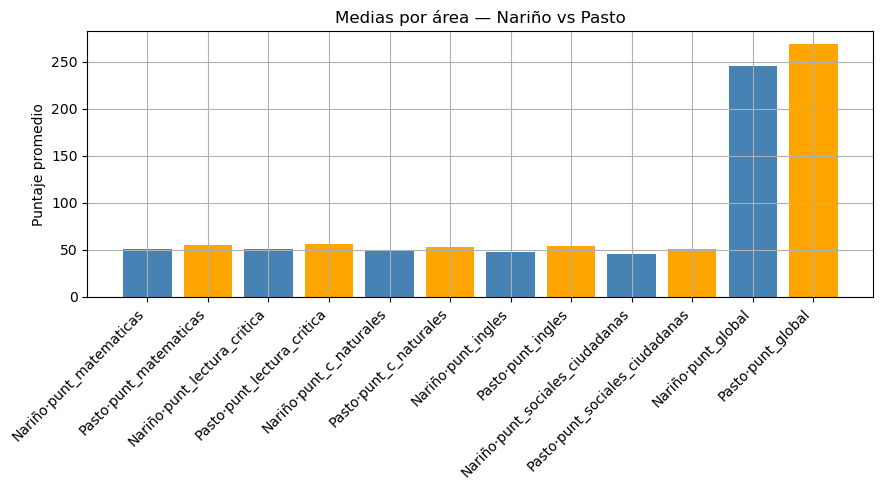

In [10]:
areas = ["punt_matematicas","punt_lectura_critica","punt_c_naturales",
         "punt_ingles","punt_sociales_ciudadanas","punt_global"]

means = []
labels = []
colors = []

for a in areas:
    if a in df_narino.columns:
        means.append(df_narino[a].mean())
        labels.append(f"Nariño·{a}")
        colors.append("steelblue")   # color para Nariño
    if a in df_pasto.columns:
        means.append(df_pasto[a].mean())
        labels.append(f"Pasto·{a}")
        colors.append("orange")      # color para Pasto

plt.figure()
plt.bar(labels, means, color=colors)
plt.title("Medias por área — Nariño vs Pasto")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Puntaje promedio")
plt.tight_layout()
plt.show()


8. Medias por área — Nariño vs Pasto

En todas las áreas evaluadas (matemáticas, lectura crítica, ciencias naturales, inglés y sociales ciudadanas), Pasto presenta mejores resultados que Nariño. Las diferencias son especialmente notorias en matemáticas e inglés, lo que indica brechas específicas en competencias que podrían ser foco estratégico para medir el valor agregado universitario.


**Uso en el TFM:** orienta hipótesis de **valor agregado diferencial por competencias** (p. ej., si el baseline en matemáticas es bajo, esperar mayor VA si la universidad fortalece esta área).



## 9) Ranking de colegios (Pasto)

Se listan los **Top-10** por puntaje global promedio.  
Esto sirve para construir *perfiles de ingreso* por colegio en la futura plataforma web.


In [11]:

ranking_pasto = pd.DataFrame()
if {"cole_nombre_establecimiento","punt_global"}.issubset(df_pasto.columns):
    ranking_pasto = (df_pasto
                     .groupby("cole_nombre_establecimiento", as_index=False)["punt_global"]
                     .mean()
                     .sort_values("punt_global", ascending=False)
                     .head(10))
    display(ranking_pasto)
else:
    print("No hay columnas suficientes para el ranking.")

,cole_nombre_establecimiento,punt_global
69,LIC INTEGD DE BTO UNIVERSIDAD DE NARIAO,351.600000
14,COL SAN FRANCISCO JAVIER,338.036036
17,COLEGIO DEL SAGRADO CORAZON DE JESUS,328.388889
58,INST CHAMPAGNAT,320.075188
71,LICEO DE LA MERCED MARIDIAZ,315.031250
3,COL COMFAMILIAR DE NARIAO SIGLO XXI,310.901961
7,COL LA INMACULADA,310.100000
5,COL FILIPENSE NUESTRA SRA DE LA ESPERANZA,305.115385
61,INST SAN FRANCISCO DE ASIS,296.898305
13,COL SAN FELIPE NERI,296.161616



## 10) Exportación — **Features de entrada** para VA/CR

Se exportan datasets **limpios** y agregados que el pipeline utilizará al cruzar con Saber Pro:
- `s11_2016_narino.csv`, `s11_2016_pasto.csv` → registros individuales filtrados.
- `s11_2016_school_summary.csv` → promedio y tamaño por colegio (Nariño/Pasto).
- `s11_2016_muni_summary.csv` → promedio por municipio (Nariño).


In [12]:
from pathlib import Path
import pandas as pd

# Usa una ruta corta/sencilla (cámbiala si quieres)
out_dir = Path(r"C:\Temp\s11_2017_tfm_outputs")
out_dir.mkdir(parents=True, exist_ok=True)

punt_cols = ["punt_global","punt_matematicas","punt_lectura_critica",
             "punt_sociales_ciudadanas","punt_c_naturales","punt_ingles"]

muni_summary = df_narino

out_file = out_dir / "s11_2019_muni_summary.csv"
muni_summary.to_csv(str(out_file), index=False, encoding="utf-8-sig")  # <-- str(...)
print("✅ Guardado:", out_file)


✅ Guardado: C:\Temp\s11_2017_tfm_outputs\s11_2019_muni_summary.csv


Síntesis global del año 2019

Sociodemografía constante: mayoría de mujeres, estrato 1 y colegios oficiales.

Estabilidad en puntajes: Nariño mantiene una media global de ≈250, mientras que Pasto se sitúa en ≈270–280.

Implicación para VA/CR: las diferencias urbano-rurales y socioeconómicas siguen marcando los niveles de entrada, lo que confirma la necesidad de modelar con variables de control para obtener una medición justa del impacto institucional.